This script is going to replicate the deep learning model behind the 2017 paper [PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts](https://https://arxiv.org/abs/1710.06071), which classifies abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature and dive deeper when necessary.

The following topics are mainly covered:
* Downloading a text dataset (PubMed RCT200k from GitHub)
* Writing a preprocessing function to prepare our data for modelling
* Setting up a series of modelling experiments
    * Making a baseline (TF-IDF classifier)
    * Deep models with different combinations of: **token embeddings**, **character embeddings**, **pretrained embeddings**, positional embeddings
* Building our first multimodal model (taking multiple types of data inputs)
* Replicating the model architecture from https://arxiv.org/pdf/1612.05251.pdf
* Find the most wrong predictions
* Making predictions on PubMed abstracts from the wild

# Setup

In [140]:
import os
import json
import string
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization, Embedding
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from spacy.lang.en import English

In [2]:
# Check for GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
# Import helper functions
!wget https://raw.githubusercontent.com/jinglan-shi/TensorFlow-Certificate-Preparation/main/extras/helper_functions.py

--2022-08-02 19:26:30--  https://raw.githubusercontent.com/jinglan-shi/TensorFlow-Certificate-Preparation/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18653 (18K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  18.22K  --.-KB/s    in 0.002s  

2022-08-02 19:26:30 (10.9 MB/s) - ‘helper_functions.py’ saved [18653/18653]



In [4]:
from helper_functions import calculate_results

# Prepare data

## Download data

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [6]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [7]:
# Get path to each dataset in the file
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

In [8]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and return the lines of text as a list.

  Args: 
    filename: a string containing the target filepath to read.

  Returns:
    A list of strings with on string per line from the target filename.
  """
  with open(filename, 'r') as f:
    return f.readlines()

In [9]:
# Check the train dataset
train_lines = get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in a filename, reads its contents and sort through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract, and what sentence number
  the target line is.

  Args:
    filename: a string of the target text file to read and extract line data from.
  
  Returns:
    A list of dictionaries each containing a line from an abstract,
    the line's label, the line's position in the abstract, and the total number
    of lines in the abstract where the line is from.

    For example:
     [{"target": 'CONCLUSION',
       "text": The study couldn't have gone better, turns out people are kinder than you think",
       "line_number": 8,
       "total_lines": 8}]
  """
  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ''
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1]
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line
  
  return abstract_samples

In [11]:
# Preprocess all three datasets
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+'test.txt')

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 423 ms, sys: 125 ms, total: 548 ms
Wall time: 555 ms


In [12]:
# Check an example from the dataset
train_samples[:12]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'Secondary outcome measures include

In [13]:
# Turn the list of into Pandas's DataFrame to visualize better
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [14]:
train_df[:20]

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [15]:
# Check the dictribution of the labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

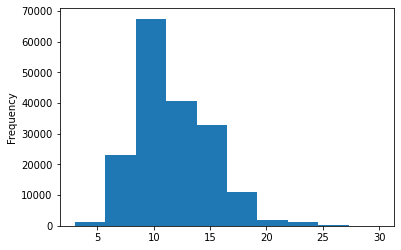

In [16]:
# Check the distribution of abstract lengths
train_df.total_lines.plot.hist();

In [17]:
# Convert text into list of sentences
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [18]:
# View the first 10 sentences of the train sentences
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

## Make numeric labels

In [114]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

# Check what training labels looks like
train_labels_one_hot[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [20]:
# Encode labels into integers
label_encoder = LabelEncoder()

train_labels_integer = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_integer = label_encoder.transform(val_df['target'].to_numpy())
test_labels_integer = label_encoder.transform(test_df['target'].to_numpy())

# Check what training labels looks like
train_labels_integer[:10]

array([3, 2, 2, 2, 2, 2, 4, 4, 4, 4])

In [21]:
# Get number of classes and class names
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Prepare data for deep sequence models
1. A vectorization layer will convert text into numbers and
2. An embedding layer will capture the relationships between those numbers.

### Text vectorization

In [22]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

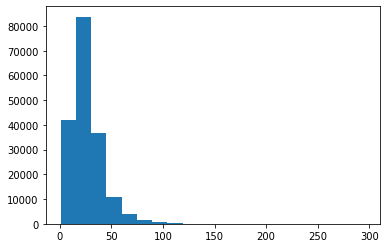

In [23]:
# Check the distribution of sentence length
plt.hist(sent_lens, bins=20);

In [24]:
# How long of a sentence covers 95% of the length
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [25]:
# Create TextVectorization layer
max_tokens = 68000 # Get from the paper

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

# Adapt text vectorizer to train sentences
text_vectorizer.adapt(train_sentences)

In [26]:
# Check an example from the train sentences
sample_sentence = random.choice(train_sentences)
print(f'Text:\n{sample_sentence}')
print(f'\nLength of text: {len(sample_sentence.split())}')
print(f'\nVectorized text:\n {text_vectorizer([sample_sentence])}')

Text:
Future research should attempt to elucidate via which pathways this association might act .

Length of text: 14

Vectorized text:
 [[ 652  285  406 2699    6 5145  598  126 2819   23  423  640 1706    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [27]:
# Check the vocabulary in the train text
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocabulary: {len(rct_20k_text_vocab)}')
print(f'5 most common words in vocabulary: {rct_20k_text_vocab[:5]}')
print(f'5 least common words in vocabulary: {rct_20k_text_vocab[-5:]}')

Number of words in vocabulary: 64841
5 most common words in vocabulary: ['', '[UNK]', 'the', 'and', 'of']
5 least common words in vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [28]:
# Get the configuration of the text_vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Embedding layer

In [29]:
# Create token embedding layer
token_embedding = Embedding(input_dim=len(rct_20k_text_vocab),
                            output_dim=128,
                            mask_zero=True,
                            name='token_embedding')

In [30]:
# Show example embedding
print(f'Sentence before vectorization:\n{sample_sentence}')
print(f'\nSentence after vectorization but before embedding:\n{text_vectorizer([sample_sentence])}')
print(f'\nSentence after embedding:\n{token_embedding(text_vectorizer([sample_sentence]))}')
print(f'\nShape of embedded sentence:\n{token_embedding(text_vectorizer([sample_sentence])).shape}')

Sentence before vectorization:
Future research should attempt to elucidate via which pathways this association might act .

Sentence after vectorization but before embedding:
[[ 652  285  406 2699    6 5145  598  126 2819   23  423  640 1706    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[-0.0051324  -0.02643684 -0.02271833 ...  0.01981005  0.01418451
    0.03652251]
  [ 0.04335265 -0.02057208  0.03188713 ... -0.01115683 -0.0271031
   -0.00530728]
  [-0.02241807 -0.00108143  0.00080767 ... -0.01279695  0.03926961
    0.00561079]
  ...
  [-0.01501182  0.04148788 -0.02093936 ... -0.04225982  0.031203
    0.04246739]
  [-0.01501182  0.04148788 -0.02093936 ... -0.04225982  0.031203
    0.04246739]
  [-0.01501182  0.04148788 -0.02093936 ... -0.04225982  0.031203
    0.04246739]]]

Shape of embe

### Create TensorFlow Datasets

In [31]:
# Turn data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_ont_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [32]:
# Configure for batter performance (not shuffle as the oeder of abstract sentences actually has some pattern)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Modelling experiments

## Model 0: Baseline model

In [33]:
# Create a pipeline
model_0 = Pipeline([('tf-idf', TfidfVectorizer()),
                    ('clf', MultinomialNB())])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
           y=train_labels_integer)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [34]:
# Evaluate baseline model on validation data
model_0.score(X=val_sentences, y=val_labels_integer)

0.7218323844829869

In [35]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [36]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_integer,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 1: Conv1D with token embeddings

In [37]:
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embedding(x)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [38]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [39]:
model_1_history = model_1.fit(train_dataset,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             epochs=3,
                             validation_data=val_dataset,
                             validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 58s 102ms/step - loss: 0.9209 - accuracy: 0.6331 - val_loss: 0.6763 - val_accuracy: 0.7417
Epoch 2/3
562/562 [==============================] - 62s 110ms/step - loss: 0.6474 - accuracy: 0.7618 - val_loss: 0.6246 - val_accuracy: 0.7736
Epoch 3/3
562/562 [==============================] - 85s 151ms/step - loss: 0.6103 - accuracy: 0.7786 - val_loss: 0.5915 - val_accuracy: 0.7869


In [40]:
# Evaluate on whole validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 8s 9ms/step - loss: 0.5921 - accuracy: 0.7875


[0.5920753479003906, 0.7875016331672668]

In [41]:
# Make predictions
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs

array([[4.70926344e-01, 1.36427909e-01, 5.63184172e-02, 3.14056158e-01,
        2.22711526e-02],
       [4.18303788e-01, 2.94954628e-01, 1.35197295e-02, 2.61625499e-01,
        1.15964124e-02],
       [1.35317966e-01, 3.89136514e-03, 1.32052973e-03, 8.59416664e-01,
        5.35029285e-05],
       ...,
       [6.37879020e-06, 6.88380329e-04, 5.84210793e-04, 3.99254077e-06,
        9.98717070e-01],
       [4.95486595e-02, 4.50698018e-01, 9.85797793e-02, 5.87829985e-02,
        3.42390627e-01],
       [1.79911137e-01, 6.99838400e-01, 4.73947488e-02, 4.00347784e-02,
        3.28208692e-02]], dtype=float32)

In [42]:
# Convert probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [43]:
# Calculate metrics results
model_1_results = calculate_results(val_labels_integer, model_1_preds)
model_1_results

{'accuracy': 78.75016549715345,
 'f1': 0.7851632367285569,
 'precision': 0.7843781442913806,
 'recall': 0.7875016549715345}

## Model 2: Feature extraction with pretrained token embeddings

In [44]:
# Download a pretrained TensorFlow Hub USE
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [45]:
# Define feature extracting model using TF Hub layer
inputs = tf.keras.Input(shape=[], dtype=tf.string)
x = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [46]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [47]:
# Fit feature extractor model for 3 epochs
model_2_history = model_2.fit(train_dataset,
                             steps_per_epoch=int(0.1 * len(train_dataset)),
                             epochs=3,
                             validation_data=val_dataset,
                             validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 10s 14ms/step - loss: 0.9155 - accuracy: 0.6500 - val_loss: 0.7959 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7697 - accuracy: 0.7001 - val_loss: 0.7538 - val_accuracy: 0.7051
Epoch 3/3
562/562 [==============================] - 8s 13ms/step - loss: 0.7515 - accuracy: 0.7125 - val_loss: 0.7349 - val_accuracy: 0.7168


In [48]:
# Evaluate on whole validation dataset
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7392 - accuracy: 0.7153


[0.7392287254333496, 0.715278685092926]

In [49]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

array([[3.8836464e-01, 3.8202563e-01, 2.7321710e-03, 2.1802555e-01,
        8.8520218e-03],
       [3.6487639e-01, 4.8204008e-01, 6.2268698e-03, 1.4336230e-01,
        3.4943300e-03],
       [2.3742676e-01, 1.2305861e-01, 1.7864905e-02, 5.8134782e-01,
        4.0301848e-02],
       ...,
       [2.4431311e-03, 6.9148540e-03, 5.7705782e-02, 8.8618993e-04,
        9.3205005e-01],
       [3.3305257e-03, 4.6335731e-02, 1.9887745e-01, 1.2648558e-03,
        7.5019139e-01],
       [1.4054060e-01, 2.3701249e-01, 5.6322050e-01, 6.4574531e-03,
        5.2769039e-02]], dtype=float32)

In [50]:
# Convert probabilities into classes
model_2_preds = tf.argmax(model_1_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [51]:
# Calculate metrics results
model_2_results = calculate_results(val_labels_integer, model_2_preds)
model_2_results

{'accuracy': 78.75016549715345,
 'f1': 0.7851632367285569,
 'precision': 0.7843781442913806,
 'recall': 0.7875016549715345}

## Model 3: Conv1D with character embeddings

In [52]:
# Make a function to split sentences into characters
def split_char(text):
  return ' '.join(list(text))

In [53]:
# Test on random sample
split_char(sample_sentence)

'F u t u r e   r e s e a r c h   s h o u l d   a t t e m p t   t o   e l u c i d a t e   v i a   w h i c h   p a t h w a y s   t h i s   a s s o c i a t i o n   m i g h t   a c t   .'

In [54]:
# Split sequence-level data into character-level data
train_chars = [split_char(sentence) for sentence in train_sentences]
val_chars = [split_char(sentence) for sentence in val_sentences]
test_chars = [split_char(sentence) for sentence in test_sentences]

In [55]:
# Check the average length of character-level sequence
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

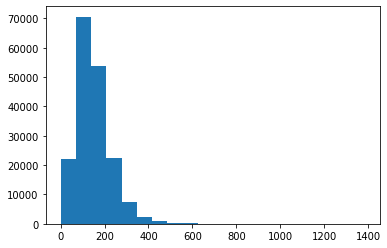

In [56]:
# Plot the distribution of character-level sequence
plt.hist(char_lens, bins=20);

In [57]:
# Find what character length covers 95% of sequences
output_seq_char_len = np.percentile(char_lens, 95)
output_seq_char_len

290.0

In [58]:
# Get all keyboard characters for char-level embedding
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [59]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    standardize='lower_and_strip_punctuation',
                                    output_sequence_length=int(output_seq_char_len),
                                    name='char_vectorizer')

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [60]:
# Check character level vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [61]:
# Test the char_vectorizer on random sample
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n{random_train_chars}')
print(f'\nLength of chars: {len(random_train_chars)}')
print(f'\nVectorized chars: {char_vectorizer(random_train_chars)}')
print(f'\nLength of vectorized chars: {len(char_vectorizer(random_train_chars))}')

Charified text:
C l i n i c a l t r i a l s . g o v   N C T @   .

Length of chars: 49

Vectorized chars: [11 12  4  6  4 11  5 12  3  8  4  5 12  9 18  7 21  6 11  3  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]

Length of

In [62]:
# Create a character-level embedding
char_embedding = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                                  output_dim=25,
                                  mask_zero=False,
                                  name='char_embedding')

In [63]:
# Test out the embedding payer
print(f'Charified text (before vectorization and embedding):\n{random_train_chars}\n')
print(f'Embedded chars (after vectorization and embedding:\n{char_embedding(char_vectorizer(random_train_chars))}\n')
print(f'Character embedding shape: {char_embedding(char_vectorizer(random_train_chars)).shape}')

Charified text (before vectorization and embedding):
C l i n i c a l t r i a l s . g o v   N C T @   .

Embedded chars (after vectorization and embedding:
[[ 0.02516094  0.0147245  -0.04045042 ... -0.02265461  0.00773034
   0.02677882]
 [ 0.00420298  0.00452244 -0.00288693 ...  0.00349965 -0.01131728
  -0.02118553]
 [ 0.02828736 -0.01054629 -0.04186138 ... -0.04200376  0.02180688
   0.02400775]
 ...
 [-0.02482669 -0.02531998  0.02906997 ... -0.04564823  0.00574136
   0.01536553]
 [-0.02482669 -0.02531998  0.02906997 ... -0.04564823  0.00574136
   0.01536553]
 [-0.02482669 -0.02531998  0.02906997 ... -0.04564823  0.00574136
   0.01536553]]

Character embedding shape: (290, 25)


In [64]:
# Make Conv1D on chars only
inputs = tf.keras.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_conv1D_char_embedding')

# Compile the model
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [65]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [66]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [67]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                             steps_per_epoch=int(0.1 * len(train_char_dataset)),
                             epochs=3,
                             validation_data=val_char_dataset,
                             validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 24ms/step - loss: 1.2485 - accuracy: 0.4968 - val_loss: 1.0315 - val_accuracy: 0.5874
Epoch 2/3
562/562 [==============================] - 16s 28ms/step - loss: 1.0006 - accuracy: 0.5983 - val_loss: 0.9269 - val_accuracy: 0.6316
Epoch 3/3
562/562 [==============================] - 17s 30ms/step - loss: 0.9223 - accuracy: 0.6385 - val_loss: 0.8627 - val_accuracy: 0.6629


In [68]:
# Evaluate on whole validation dataset
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 7s 8ms/step - loss: 0.8866 - accuracy: 0.6538


[0.8865602612495422, 0.6538130640983582]

In [69]:
# Make predictions
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.1857078 , 0.50191385, 0.06736537, 0.21096262, 0.03405031],
       [0.07725104, 0.17969976, 0.01042068, 0.7228692 , 0.00975933],
       [0.07880069, 0.26732847, 0.06884759, 0.57421076, 0.01081244],
       ...,
       [0.04162675, 0.06376407, 0.28390577, 0.05154043, 0.559163  ],
       [0.04534541, 0.21280909, 0.22794513, 0.08178136, 0.432119  ],
       [0.5184746 , 0.2650335 , 0.13748392, 0.05907641, 0.01993147]],
      dtype=float32)

In [70]:
# Convert probabilities into classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 4, 0])>

In [71]:
# Calculate metrics results
model_3_results = calculate_results(val_labels_integer, model_3_preds)
model_3_results

{'accuracy': 65.3813054415464,
 'f1': 0.6435944860859801,
 'precision': 0.6512499511271628,
 'recall': 0.653813054415464}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [72]:
# 1. Setup token inputs/model
token_inputs = tf.keras.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Setup char inputs/model
char_inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with token and char inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_4_token_char_embeddings')

In [73]:
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['tok

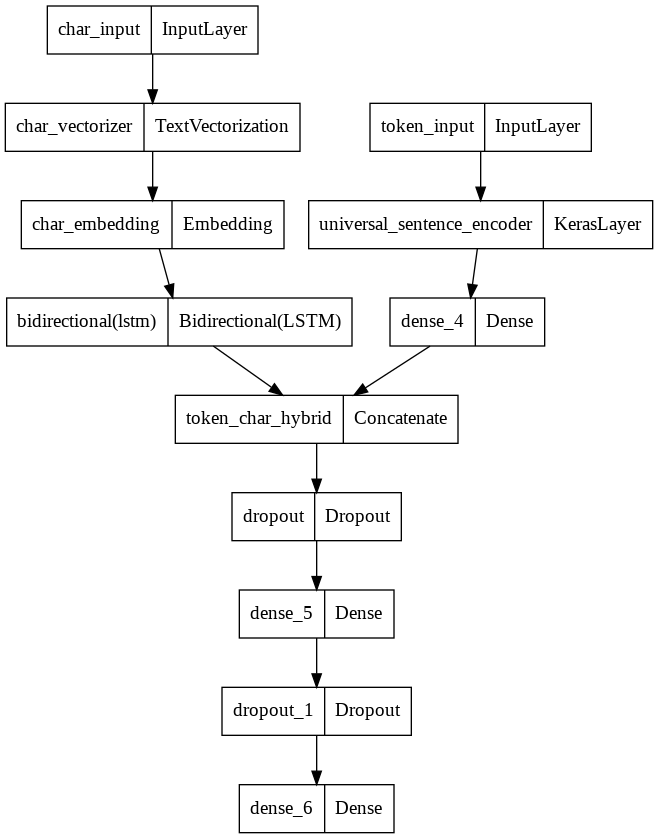

In [74]:
plot_model(model_4)

In [75]:
# Compile token char model
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [76]:
# Combine token and character data into dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels))

# Batch and prefetch the train dataset
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps for validation dataset
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels))
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [77]:
# Check out training char and token embedding dataset
train_token_char_dataset, val_token_char_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [78]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_token_char_dataset,
                             steps_per_epoch=int(0.1 * len(train_token_char_dataset)),
                             epochs=3,
                             validation_data=val_token_char_dataset,
                             validation_steps=int(0.1 * len(val_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 141s 243ms/step - loss: 0.9695 - accuracy: 0.6145 - val_loss: 0.7871 - val_accuracy: 0.6961
Epoch 2/3
562/562 [==============================] - 131s 233ms/step - loss: 0.7902 - accuracy: 0.6965 - val_loss: 0.7116 - val_accuracy: 0.7360
Epoch 3/3
562/562 [==============================] - 143s 255ms/step - loss: 0.7664 - accuracy: 0.7084 - val_loss: 0.6837 - val_accuracy: 0.7367


In [79]:
# Evaluate the model on whole validation dataset
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 55s 58ms/step - loss: 0.6868 - accuracy: 0.7371


[0.6868388652801514, 0.7370912432670593]

In [80]:
# Make predictions
model_4_pred_probs = model_4.predict(val_token_char_dataset)
model_4_pred_probs

array([[4.5231214e-01, 3.1362000e-01, 4.0675243e-03, 2.2392502e-01,
        6.0752397e-03],
       [2.9994673e-01, 5.3008378e-01, 6.0965037e-03, 1.6062157e-01,
        3.2513940e-03],
       [3.6218140e-01, 1.6042928e-01, 5.1135715e-02, 3.8181263e-01,
        4.4441070e-02],
       ...,
       [3.8845491e-04, 4.5821834e-03, 4.7031272e-02, 1.1537067e-04,
        9.4788265e-01],
       [5.2541671e-03, 5.0370950e-02, 2.1029070e-01, 3.1690020e-03,
        7.3091525e-01],
       [1.9431609e-01, 3.6378083e-01, 3.7912589e-01, 2.1957073e-02,
        4.0820129e-02]], dtype=float32)

In [81]:
# Convert probabilities into classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [82]:
# Calculate metrics results
model_4_results = calculate_results(val_labels_integer, model_4_preds)
model_4_results

{'accuracy': 73.7091222030981,
 'f1': 0.7337911860946772,
 'precision': 0.7356180154189823,
 'recall': 0.7370912220309811}

## Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [83]:
# Inspect train dataframe
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
...,...,...,...,...
180035,RESULTS,For the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"For PAV , a significantly greater percentage o...",8,11
180037,RESULTS,Both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"Compared with standard statin monotherapy , th...",10,11


In [84]:
# How many different line numbers are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

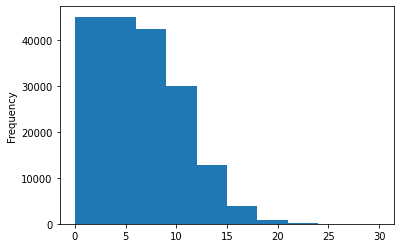

In [85]:
# Check the distribution of 'line_number' column
train_df.line_number.plot.hist()

The majority of lines have a line_number of 15 or less.

In [86]:
# One-hot encode the 'line_number' column
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

In [87]:
# Check one-hot encoded "line_number" feature samples
train_line_number_one_hot[:10], train_line_number_one_hot[:10].shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([10, 15]))

In [88]:
# Do the same steps for 'total_lines'
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

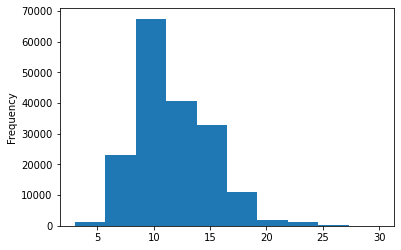

In [89]:
train_df['total_lines'].plot.hist()

In [90]:
# Check the 98 coverage of the total_lines
np.percentile(train_df['total_lines'], 98)

20.0

In [91]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

In [92]:
# 1. Token inputs
token_inputs = tf.keras.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Char inputs
char_inputs = tf.keras.Input(shape=(1,), dtype=tf.string, name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line number inputs
line_number_inputs = tf.keras.Input(shape=(15,), dtype=tf.int32, name='line_number_inputs')
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Total lines inputs
total_lines_inputs = tf.keras.Input(shape=(20,), dtype=tf.int32, name='total_lines_inputs')
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='token_char_embeddings')([token_model.output, char_model.output])
z = layers.Dense(256, activation='relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with the hybrid token and char embeddings into a tribrid embedding
z = layers.Concatenate(name='positional_token_char_embedding')([line_number_model.output,
                                                                total_lines_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation='softmax', name='output_layer')(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [93]:
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

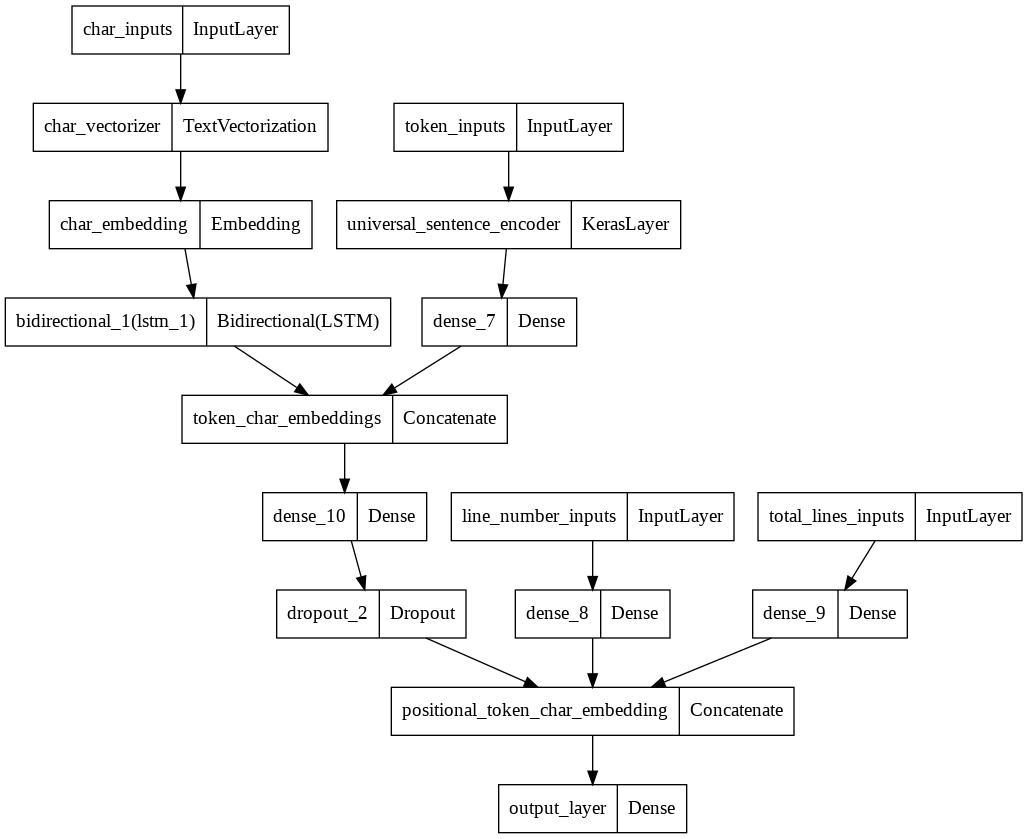

In [94]:
plot_model(model_5)

In [95]:
# Check which layers of our model are trainable or not
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f550d1daf10> True
<keras.engine.input_layer.InputLayer object at 0x7f550d245c10> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f5504f1a950> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f551cfbbd10> False
<keras.layers.embeddings.Embedding object at 0x7f550a9e3510> True
<keras.layers.core.dense.Dense object at 0x7f550d28b890> True
<keras.layers.wrappers.Bidirectional object at 0x7f550d0bb7d0> True
<keras.layers.merge.Concatenate object at 0x7f550d0ab950> True
<keras.engine.input_layer.InputLayer object at 0x7f550d0e5910> True
<keras.engine.input_layer.InputLayer object at 0x7f550d04d050> True
<keras.layers.core.dense.Dense object at 0x7f550cfd71d0> True
<keras.layers.core.dense.Dense object at 0x7f550d0ac5d0> True
<keras.layers.core.dense.Dense object at 0x7f550d0b6950> True
<keras.layers.core.dropout.Dropout object at 0x7f550d0a9c10> True
<keras.layers.merge.Concatenate object at 0x7f550d

In [96]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [116]:
# Create tribrib embedding datasets
train_pos_token_char_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_pos_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_token_char_dataset = tf.data.Dataset.zip((train_pos_token_char_data, train_pos_token_char_labels))
train_pos_token_char_dataset = train_pos_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same for validation dataset
val_pos_token_char_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_token_char_dataset = tf.data.Dataset.zip((val_pos_token_char_data, val_pos_token_char_labels))
val_pos_token_char_dataset = val_pos_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For test dataset
test_pos_token_char_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_token_char_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_token_char_dataset = tf.data.Dataset.zip((test_pos_token_char_data, test_pos_token_char_labels))
test_pos_token_char_dataset = test_pos_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [117]:
# Check the shaoe of datasets
train_pos_token_char_dataset, val_pos_token_char_dataset, test_pos_token_char_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [99]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_token_char_dataset,
                             steps_per_epoch=int(0.1 * len(train_pos_token_char_dataset)),
                             epochs=3,
                             validation_data=val_pos_token_char_dataset,
                             validation_steps=int(0.1 * len(val_pos_token_char_dataset)))

Epoch 1/3
562/562 [==============================] - 136s 233ms/step - loss: 1.0968 - accuracy: 0.7234 - val_loss: 0.9824 - val_accuracy: 0.7995
Epoch 2/3
562/562 [==============================] - 131s 232ms/step - loss: 0.9671 - accuracy: 0.8139 - val_loss: 0.9517 - val_accuracy: 0.8271
Epoch 3/3
562/562 [==============================] - 135s 240ms/step - loss: 0.9511 - accuracy: 0.8235 - val_loss: 0.9403 - val_accuracy: 0.8338


In [100]:
# Evaluate on the whole validation dataset
model_5.evaluate(val_pos_token_char_dataset)

945/945 [==============================] - 49s 52ms/step - loss: 0.9380 - accuracy: 0.8299


[0.9380272030830383, 0.8299020528793335]

In [101]:
# Make predictions
model_5_pred_probs = model_5.predict(val_pos_token_char_dataset)
model_5_pred_probs

array([[0.48314384, 0.10115948, 0.01342787, 0.38101763, 0.02125131],
       [0.53614134, 0.09531449, 0.04781553, 0.3093275 , 0.01140114],
       [0.27719748, 0.08228388, 0.10082496, 0.47121543, 0.06847826],
       ...,
       [0.03559844, 0.09812804, 0.03550486, 0.0345803 , 0.79618835],
       [0.0280305 , 0.28450775, 0.0705407 , 0.02605065, 0.5908704 ],
       [0.15666394, 0.6224082 , 0.13096325, 0.04085315, 0.0491114 ]],
      dtype=float32)

In [102]:
# Convert probabilities into classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [103]:
# Calculate metrics results
model_5_results = calculate_results(val_labels_integer, model_5_preds)
model_5_results

{'accuracy': 82.99020256851583,
 'f1': 0.8291322733725036,
 'precision': 0.8287659078310469,
 'recall': 0.8299020256851583}

# Compare models' results

In [104]:
# Create a dataframe of all models' results
all_models_results = pd.DataFrame({'baseline': baseline_results,
                                   'custom_token_embedding_conv1D': model_1_results,
                                   'pretrained_token_embedding': model_2_results,
                                   'custom_char_embedding_conv1D': model_3_results,
                                   'hybrid_token_char_embedding': model_4_results,
                                   'tribrid_pos_token_char_embedding': model_5_results}).T
all_models_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embedding_conv1D,78.750165,0.784378,0.787502,0.785163
pretrained_token_embedding,78.750165,0.784378,0.787502,0.785163
custom_char_embedding_conv1D,65.381305,0.651250,0.653813,0.643594
hybrid_token_char_embedding,73.709122,0.735618,0.737091,0.733791
tribrid_pos_token_char_embedding,82.990203,0.828766,0.829902,0.829132


In [105]:
# Reduce the scale of 'accuracy' to the level as other's
all_models_results['accuracy'] = all_models_results['accuracy']/100
all_models_results

,accuracy,precision,recall,f1
baseline,0.721832,0.718647,0.721832,0.698925
custom_token_embedding_conv1D,0.787502,0.784378,0.787502,0.785163
pretrained_token_embedding,0.787502,0.784378,0.787502,0.785163
custom_char_embedding_conv1D,0.653813,0.651250,0.653813,0.643594
hybrid_token_char_embedding,0.737091,0.735618,0.737091,0.733791
tribrid_pos_token_char_embedding,0.829902,0.828766,0.829902,0.829132


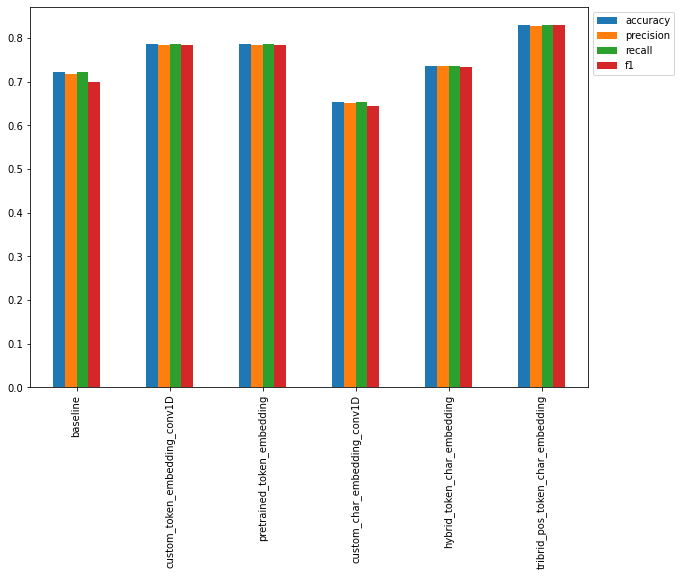

In [106]:
# Plot and compare all results
all_models_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

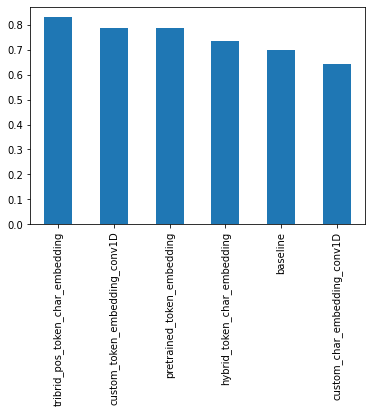

In [107]:
# Sort models results by f1-score
all_models_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7));

# Save and load the best performing model

In [109]:
# Save the best performing model to HDF5 format
model_5.save('tribrid_model')

INFO:tensorflow:Assets written to: tribrid_model/assets


INFO:tensorflow:Assets written to: tribrid_model/assets


# Make predictions on test data

In [110]:
# Load the saved model
loaded_model = tf.keras.models.load_model('tribrid_model')

In [111]:
# Evaluate loaded model to see it it's loaded properly
loaded_pred_probs = loaded_model.predict(val_pos_token_char_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_model_results = calculate_results(val_labels_integer, loaded_preds)
loaded_model_results

{'accuracy': 82.99020256851583,
 'f1': 0.8291322733725036,
 'precision': 0.8287659078310469,
 'recall': 0.8299020256851583}

In [112]:
# Compare loaded model's results with original model's results
np.isclose(list(loaded_model_results.values()), list(model_5_results.values()))

array([ True,  True,  True,  True])

In [118]:
# Make prediction on the test dataset
test_pred_probs = loaded_model.predict(test_pos_token_char_dataset)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds

<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([3, 3, 2, ..., 4, 4, 1])>

In [119]:
# Calculate metrics results
loaded_model_test_results = calculate_results(test_labels_integer, test_preds)
loaded_model_results

{'accuracy': 82.99020256851583,
 'f1': 0.8291322733725036,
 'precision': 0.8287659078310469,
 'recall': 0.8299020256851583}

# Find the most wrong predictions

In [121]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [123]:
%%time
# Get a list of predicted class names
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 12.3 s, sys: 36.9 ms, total: 12.3 s
Wall time: 13.2 s


In [125]:
# Create prediction-enriched test dataframe
test_df['prediction'] = test_pred_classes
test_df['pred_prob'] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df['correction'] = test_df['target'] == test_df['prediction']

test_df

,target,text,line_number,total_lines,prediction,pred_prob,correction
0,BACKGROUND,This study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.494027,False
1,RESULTS,A post hoc analysis was conducted with the use...,1,8,OBJECTIVE,0.342036,False
2,RESULTS,Liver function tests ( LFTs ) were measured at...,2,8,METHODS,0.781697,False
3,RESULTS,Survival analyses were used to assess the asso...,3,8,METHODS,0.627392,False
4,RESULTS,The percentage of patients with abnormal LFTs ...,4,8,RESULTS,0.702960,True
...,...,...,...,...,...,...,...
30130,RESULTS,There was a statistically significant between-...,13,17,RESULTS,0.829153,True
30131,RESULTS,There were no statistically significant betwee...,14,17,RESULTS,0.761965,True
30132,RESULTS,There was no significant association between s...,15,17,RESULTS,0.728627,True
30133,RESULTS,No adverse effects were reported .,16,17,RESULTS,0.702821,True


In [127]:
# Sort the dataframe to get the top 100 wrong predictions
top_100_wrong = test_df[test_df['correction'] == False].sort_values('pred_prob', ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correction
13874,CONCLUSIONS,Symptom outcomes will be assessed and estimate...,4,6,METHODS,0.930568,False
16347,BACKGROUND,To evaluate the effects of the lactic acid bac...,0,12,OBJECTIVE,0.928033,False
8545,METHODS,Pretest-posttest .,1,11,BACKGROUND,0.926612,False
835,BACKGROUND,To assess the temporal patterns of late gastro...,0,11,OBJECTIVE,0.920462,False
671,METHODS,To determine whether the insulin resistance th...,0,7,OBJECTIVE,0.920003,False
...,...,...,...,...,...,...,...
7823,CONCLUSIONS,"At @ year , mortality rates in the PI and pPCI...",8,10,RESULTS,0.835396,False
10089,RESULTS,Qualitative findings in the community trial al...,10,19,CONCLUSIONS,0.835303,False
23657,CONCLUSIONS,Early reintervention rate within @ d was three...,10,14,RESULTS,0.835083,False
16877,RESULTS,Primary efficacy endpoint was trough forced ex...,4,13,METHODS,0.834808,False


In [130]:
# Investigate top wrong predictions
for row in top_100_wrong[:10].itertuples():
  _, target, text, line_number, total_lines, predictions, pred_prob, _ = row
  print(f'Target: {target}, Pred: {predictions}, Prob: {pred_prob}, Line_number: {line_number}, Total_lines: {total_lines}')
  print(f'\nText:\n{text}\n')
  print('-------------------------------------------------------------------------------------------------\n')

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9305683970451355, Line_number: 4, Total_lines: 6

Text:
Symptom outcomes will be assessed and estimates of cost-effectiveness made .

-------------------------------------------------------------------------------------------------

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.928033173084259, Line_number: 0, Total_lines: 12

Text:
To evaluate the effects of the lactic acid bacterium Lactobacillus salivarius on caries risk factors .

-------------------------------------------------------------------------------------------------

Target: METHODS, Pred: BACKGROUND, Prob: 0.9266119003295898, Line_number: 1, Total_lines: 11

Text:
Pretest-posttest .

-------------------------------------------------------------------------------------------------

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.9204624891281128, Line_number: 0, Total_lines: 11

Text:
To assess the temporal patterns of late gastrointestinal ( GI ) and genitourinary ( GU ) radiother

# Make predictions on sample from the wild

In [136]:
# Download example abstracts
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
with open('skimlit_example_abstracts.json', 'r') as f:
  example_abstracts = json.load(f)

--2022-08-02 20:44:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json.1’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2022-08-02 20:44:17 (72.1 MB/s) - ‘skimlit_example_abstracts.json.1’ saved [6737/6737]



In [138]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


In [139]:
abstracts['abstract'][0]

'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.'

In [142]:
# Use spaCy to turn text into sentences
nlp = English()
sentencizer = nlp.create_pipe('sentencizer')
nlp.add_pipe('sentencizer')
doc = nlp(example_abstracts[0]['abstract'])
abstract_lines = [str(sent) for sent in list(doc.sents)]
abstract_lines

['This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
 'Participants were randomly assigned to treatment or wait-list conditions.',
 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
 'High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.',
 'Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.']

In [144]:
train_samples[:5]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'Secondary outcome measures include

In [145]:
# Get total_lines
total_lines = len(abstract_lines)

# Go through each line in abstract and create a list of distionaries containing features for each line
sample_lines = []
for index, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict['line_number'] = index
  sample_dict['text'] = str(line)
  sample_dict['total_lines'] = total_lines
  sample_lines.append(sample_dict)

sample_lines

[{'line_number': 0,
  'text': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs.',
  'total_lines': 8},
 {'line_number': 1,
  'text': 'Participants were randomly assigned to treatment or wait-list conditions.',
  'total_lines': 8},
 {'line_number': 2,
  'text': 'Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.',
  'total_lines': 8},
 {'line_number': 3,
  'text': 'A response-cost program was applied to reduce problem behaviors and foster skills acquisition.',
  'total_lines': 8},
 {'line_number': 4,
  'text': 'Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).',
  'total_lines': 8},
 {'line_number': 5,
  'text': 'Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.',
  'total_lines': 8},
 {'line_

In [147]:
# One-hot encode positional features
test_abstract_line_numbers = [line['line_number'] for line in sample_lines]

test_abstract_line_numbers_ont_hot = tf.one_hot(test_abstract_line_numbers, depth=15)
test_abstract_line_numbers_ont_hot

<tf.Tensor: shape=(8, 15), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>

In [148]:
test_abstract_total_lines = [line['total_lines'] for line in sample_lines]

test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

<tf.Tensor: shape=(8, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [150]:
# Split abstract lines into characters
abstract_chars = [split_char(sentence) for sentence in abstract_lines]
abstract_chars

['T h i s   R C T   e x a m i n e d   t h e   e f f i c a c y   o f   a   m a n u a l i z e d   s o c i a l   i n t e r v e n t i o n   f o r   c h i l d r e n   w i t h   H F A S D s .',
 'P a r t i c i p a n t s   w e r e   r a n d o m l y   a s s i g n e d   t o   t r e a t m e n t   o r   w a i t - l i s t   c o n d i t i o n s .',
 'T r e a t m e n t   i n c l u d e d   i n s t r u c t i o n   a n d   t h e r a p e u t i c   a c t i v i t i e s   t a r g e t i n g   s o c i a l   s k i l l s ,   f a c e - e m o t i o n   r e c o g n i t i o n ,   i n t e r e s t   e x p a n s i o n ,   a n d   i n t e r p r e t a t i o n   o f   n o n - l i t e r a l   l a n g u a g e .',
 'A   r e s p o n s e - c o s t   p r o g r a m   w a s   a p p l i e d   t o   r e d u c e   p r o b l e m   b e h a v i o r s   a n d   f o s t e r   s k i l l s   a c q u i s i t i o n .',
 'S i g n i f i c a n t   t r e a t m e n t   e f f e c t s   w e r e   f o u n d   f o r   f i v e   o f   s e v e n   p 

In [151]:
# Make predictions on wild samples
%%time
test_abstract_pred_probs = loaded_model.predict((test_abstract_line_numbers_ont_hot,
                                                 test_abstract_total_lines_one_hot,
                                                 tf.constant(abstract_lines),
                                                 tf.constant(abstract_chars)))
test_abstract_preds = tf.argmax(test_abstract_pred_probs, axis=1)

CPU times: user 2.58 s, sys: 55.4 ms, total: 2.64 s
Wall time: 2.77 s


In [152]:
test_abstract_preds

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([3, 2, 2, 2, 2, 2, 4, 4])>

In [155]:
# Visualize the predicted labels along with it's original text
for sentence, label in zip(abstract_lines, test_abstract_preds.numpy()):
  print(f'Prediction: {label_encoder.classes_[label]}\nText:\n{sentence}\n')

Prediction: OBJECTIVE
Text:
This RCT examined the efficacy of a manualized social intervention for children with HFASDs.

Prediction: METHODS
Text:
Participants were randomly assigned to treatment or wait-list conditions.

Prediction: METHODS
Text:
Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.

Prediction: METHODS
Text:
A response-cost program was applied to reduce problem behaviors and foster skills acquisition.

Prediction: METHODS
Text:
Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).

Prediction: METHODS
Text:
Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.

Prediction: RESULTS
Text:
High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.

Prediction: RESULTS
Text:
St